INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
starting CapsNet (32, 32, 1) 10 3 100


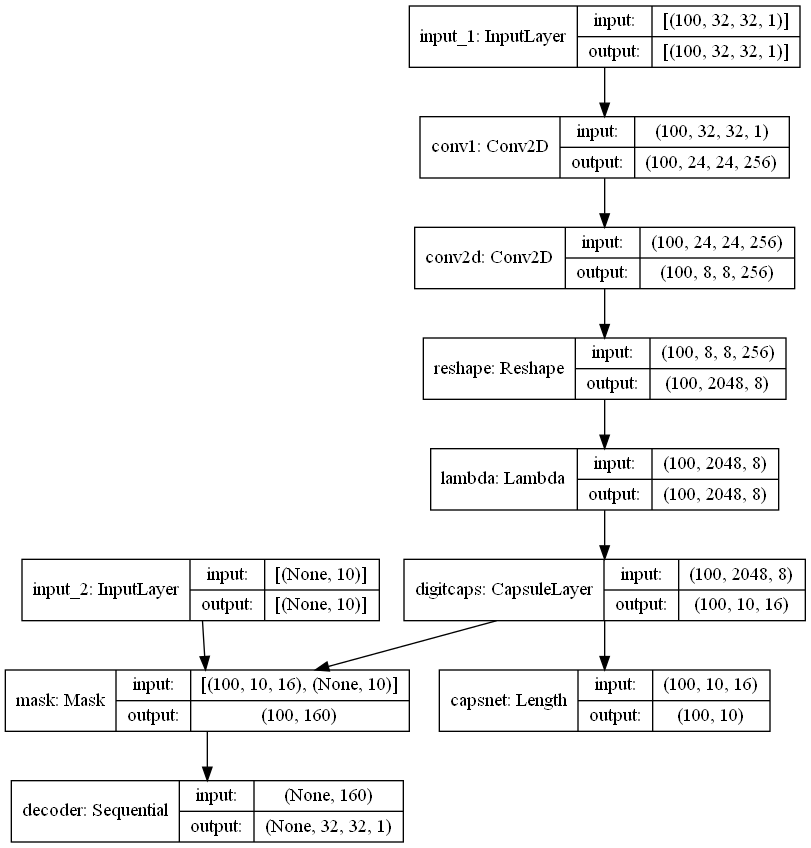

In [1]:
import tensorflow as tf
from tensorflow.keras import optimizers
from capsnet.capsnet import CapsNet
from utils.utils import plot_log
from metrics import margin_loss

ROUTINGS = 3
BATCH_SIZE = 100
INPUT_SHAPE = (32, 32, 1)

model, eval_model, manipulate_model = CapsNet(input_shape=INPUT_SHAPE,
                                                  n_class=10,
                                                  routings=ROUTINGS,
                                                  batch_size=BATCH_SIZE)

lr = 0.001
lam_recon = 0.392
# compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                loss=[margin_loss, 'mse'],
                loss_weights=[1., lam_recon],
                metrics={'capsnet': 'accuracy'})

save_dir='./result/capsnet_cifar/capsnet_triplets-mono'
weights = './result/capsnet_cifar/capsnet_cifar_mono/trained_model.h5'
model_img = save_dir + '/model.png'
model.load_weights(weights)
tf.keras.utils.plot_model(model, to_file=model_img, show_shapes=True)

# plot_log(save_dir + '/log.csv', show=True)


In [2]:
from tensorflow.keras import layers, models, optimizers

input_a = layers.Input(name="anchor", shape=INPUT_SHAPE)
input_p = layers.Input(name="positive", shape=INPUT_SHAPE)
input_n = layers.Input(name="negative", shape=INPUT_SHAPE)

embedding_a = eval_model(input_a)
embedding_p = eval_model(input_p)
embedding_n = eval_model(input_n)

output = layers.concatenate([embedding_a, embedding_p, embedding_n], axis=1)
# print(output)

siamese_net = models.Model([input_a, input_p, input_n], output)
siamese_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (100, 32, 32, 1)     9608448     anchor[0][0]                     
                                                                 positive[0][0]             

In [3]:
import tensorflow as tf
import numpy as np
from images import create_batch, images_train, images_valid
from metrics import get_callbacks, emb_size

alpha = 0.2
def accuracy(y_true, y_pred):
    anchor, positive, negative = y_pred[:, :emb_size], y_pred[:,
                                                              emb_size:2*emb_size], y_pred[:, 2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return positive_dist + alpha < negative_dist

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:, :emb_size], y_pred[:,
                                                              emb_size:2*emb_size], y_pred[:, 2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    L = tf.maximum(positive_dist - negative_dist + alpha, 0.)
    # tf.print(L)
    return L


def data_generator(images):
    while True:
        x = create_batch(images, INPUT_SHAPE, 1)
        y = np.zeros((100, 3*emb_size))
        yield [x[0], x[1], x[2]], y

# data_generator().send(None)[0][0].shape

lr = 0.00006
net_callbacks = get_callbacks(save_dir, lr, 0.9, 'val_accuracy')
optimiser_obj = optimizers.Adam(learning_rate=lr)
siamese_net.compile(loss=triplet_loss, optimizer=optimiser_obj,
                    metrics=[accuracy])
run_fit = False

if(run_fit):
    siamese_net.fit(
        data_generator(images_train),
        steps_per_epoch=int(len(images_train)/BATCH_SIZE),
        epochs=30,
        validation_data=data_generator(images_valid),
        validation_steps=int(len(images_valid)/BATCH_SIZE),
        callbacks=[net_callbacks])

    siamese_net.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)
else:
    siamese_net.load_weights(save_dir + '/trained_model.h5')
# plot_log(save_dir + '/log.csv', show=True)

c:\Users\Tautvydas\Documents\magistras\master_capsnet\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0-rc2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [4]:
from images import preprocess_image_with_angle, images_test
# get 100 test images
# images_test_eval = []
INPUT_SHAPE = (32, 32, 1)
x_a = np.zeros((BATCH_SIZE*10, *INPUT_SHAPE))  # * - expands tuple
x_p = np.zeros((BATCH_SIZE*10, *INPUT_SHAPE))  # * - expands tuple
x_n = np.zeros((BATCH_SIZE*10, *INPUT_SHAPE))  # * - expands tuple
for i in range(10):
    for j in range(10):
        for angle in range(10):
            image_a = preprocess_image_with_angle(
                images_test[i*3], angle, 10, 1)
            image_p = preprocess_image_with_angle(
                images_test[i*3+1], 0, 10, 1)
            image_n = preprocess_image_with_angle(
                images_test[j*3+2], 0, 10, 1)
            x_a[i*100 + j*10 + angle] = image_a
            x_p[i*100 + j*10 + angle] = image_p
            x_n[i*100 + j*10 + angle] = image_n
images_test_eval = np.array([x_a, x_p, x_n])
images_test_eval.shape, len(images_test)

((3, 1000, 32, 32, 1), 30)

(1000, 96, 32, 1) (1000, 96, 32, 1)
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_triplets-mono/triplet_recon.png
------------------------------End: test------------------------------


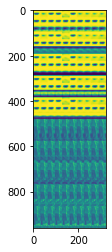

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import combine_images
file_name = "triplet_recon"
x_recon = siamese_net.predict([x_a, x_p, x_n], batch_size=100)
images_test_eval_x = np.concatenate(images_test_eval, axis=1)
print(x_recon.shape, images_test_eval_x.shape)
# img = combine_images(np.concatenate([x_recon[:3], x_recon[10:13]]))
img = combine_images(np.concatenate([x_recon[:50], images_test_eval_x[:50]]))
def print_combined_embeddings(image, save_dir, file_name):
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(
            save_dir + "/" + file_name + ".png")
    print('Reconstructed images are saved to %s/%s.png' %
            (save_dir, file_name))
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(save_dir + "/" + file_name + ".png"))
    plt.show()
print_combined_embeddings(img, save_dir, file_name)

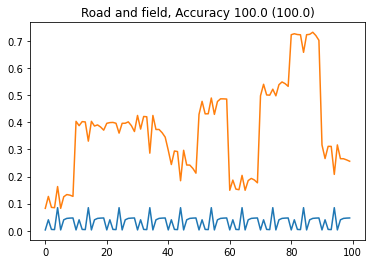

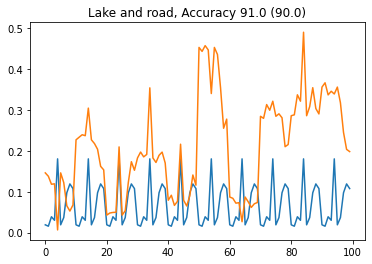

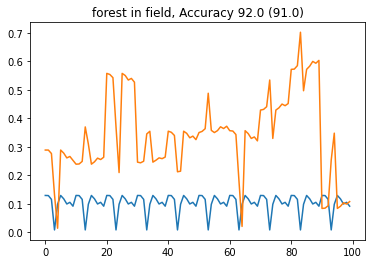

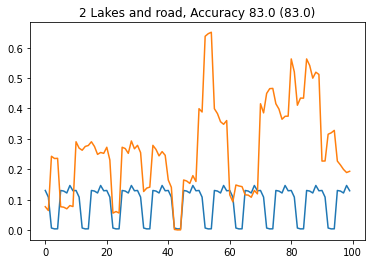

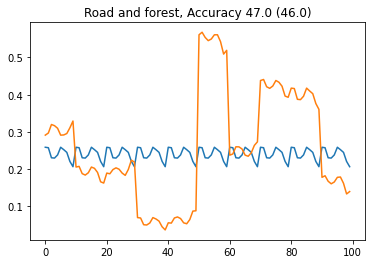

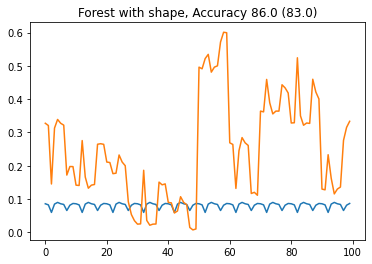

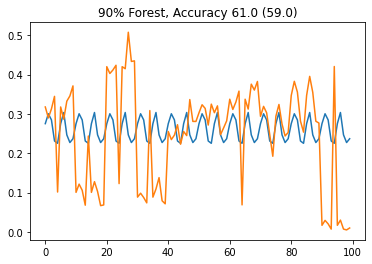

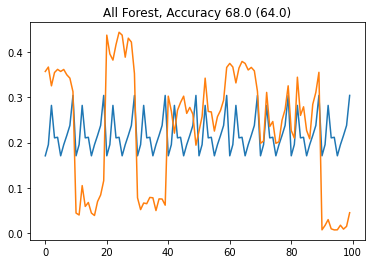

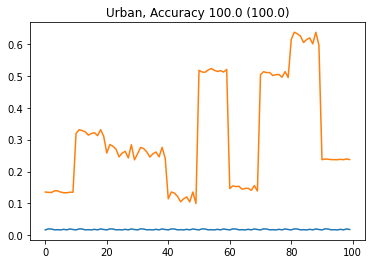

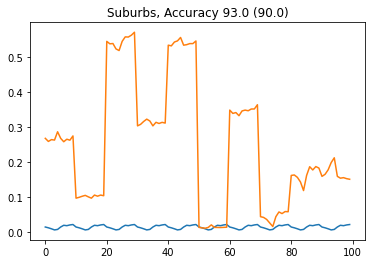

0.821 0.806


In [8]:
from utils.utils import show_graphs
show_graphs(x_recon, emb_size, 'graphs/capsnet_mono/')